In [1]:
#Tarea 3 - Actividad 3

In [49]:
from matplotlib import pyplot
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd
from numba import jit, njit
from IPython.display import Image

In [50]:
#Definimos la función para generar el estado inicial de la muestra aleatoria
def muestraInicial(nr, N):
    i = 0
    muestraX = []
    muestraY = []
    muestraZ = []
    rad = 0.5
    L = np.sqrt(N/nr)/2 #Calculamos la longitud de la celda de tal modo que quede centrada
    while i < N:
        err = False
        x_n = np.random.rand()*(2*L - 2*rad) + (-L+rad)
        y_n = np.random.rand()*(2*L - 2*rad) + (-L+rad)
        z_n = np.random.rand()*(2*L - 2*rad) + (-L+rad)
        if i == 0: #La primer coordenada simplemente la agregamos a la lista
            muestraX.append(x_n)
            muestraY.append(y_n)
            muestraZ.append(z_n)
            i = i + 1
        elif i > 0: #A partir de la segunda coordenada generada comenzamos a evaluar las distancias entre los puntos
            for j in range(len(muestraX)):
                dist = np.sqrt((x_n - muestraX[j])**2 + (y_n - muestraY[j])**2 + (z_n - muestraZ[j])**2)
                if dist<2*rad: #Si la distancia es menor a dos veces el radio paramos la iteración e indicamos que hay un error con el valor generado 
                    err = True
                    break
                else:
                    continue
            if err == False: #Si no hay un error registrado entonces agregamos la coordenada generada a la lista
                muestraX.append(x_n)
                muestraY.append(y_n)
                muestraZ.append(z_n)
                i = i + 1
    return muestraX, muestraY, muestraZ

In [74]:
#Definimos la función que calcula el potencial total del sistema de partículas en su estado inicial
#Utilizaremos como argumentos el número de partículas, la longitud de la celda, el radio de corte, y los arreglos de posiciones
#de las partículas
@njit
def V_0(N, L, radC, x, y, z):
    V = 0
    i = 0
#Iniciamos un bule para seleccionar la partícula
    while i < N:
        xi = x[i]
        yi = y[i]
        zi = z[i]
#Empezamos el bucle para calcular la distancia entre la partícula seleccionada y todas las demás
#se evalua si la distancia es mayor al radio de corte y se determina la aportación al potencial
        for j in range(i+1, N):
            xij = (xi - x[j])
            yij = (yi - y[j])
            zij = (zi - z[j])
            xij = xij - L*round(xij/L) #Aplicando la condición de imagen mínima
            yij = yij - L*round(yij/L) #Aplicando la condición de imagen mínima
            zij = zij - L*round(zij/L) #Aplicando la condición de imagen mínima
            rij = np.sqrt(xij**2 + yij**2 + zij**2)
            if rij < radC:
                if rij <= 1.:
                    Vij = np.inf
                elif rij > 1. and rij <1.25:
                    Vij = -1.0E+10
                elif rij >= 1.25:
                    Vij = 0
                V = V + Vij
        i = i +1
    return V

In [82]:
#Definimos la función que calcula la energía potencial de la j-ésima partícula en el i-ésimo estado
#Utilizamos de argumentos el número de partículas, la longitud de la celda, los arreglos de posiciones
#en "x" y "y", las posiciones de la partícula de la cual se quiere saber el potencial,  
@njit
def V_j(N, L, radC, x, y, z, xj, yj, zj, j):
    V = 0
    i = 0
    while i < N:
        if j != i:
            xij = xj - x[i]
            yij = yj - y[i]
            zij = zj - z[i]
            xij = xij - L*round(xij/L) #Aplicando la condición de imagen mínima
            yij = yij - L*round(yij/L) #Aplicando la condición de imagen mínima
            zij = zij - L*round(zij/L) #Aplicando la condición de imagen mínima
            rij = np.sqrt(xij**2 + yij**2 + zij**2)
            if rij < radC:
                if rij <= 1.:
                    Vij = np.inf
                elif rij > 1. and rij < 1.25:
                    Vij = -1.0E+10
                elif rij >= 1.25:
                    Vij = 0
                V = V + Vij
        i = i + 1
    return V
#Esta función se utilizará dentro de la función de movimiento de las partículas

In [83]:
#Definimos la función de movimiento de las partículas
#Utilizamos como argumento los arreglos de las posiciones en "x", "y", "z", el número de partículas, la longitud de la celda,
#el número de estados, el radio de corte, la distancia máxima que pueden moverse las partículas, la frecuencia de corrección
#de paso, la frecuencia con la que se imprimen datos en pantalla, el criterio de correción, el potencial del estado inicial,
#la partícula trazadora y la corrección de largo alcance.
@njit
def movPart(x, y, z, N, L, nStep, radC, drMax, iRatio, iPrint, cc, V, iTraza, Vlrc):
    numIter = 0 #Contador de iteraciones exitosas antes de cambiar el valor de la distancia máxima
    xTraza = np.zeros(nStep)
    yTraza = np.zeros(nStep)
    zTraza = np.zeros(nStep)
    vTraza = np.zeros(nStep)
#Abrimos un bucle para calcular el potencial de la j-ésima partícula en el i-ésimo estado con la función de potencial definida
#anteriormente, calcular la nueva posición, luego el nuevo potencial, y luego la diferencia de potencial entre estados
    for i in range(nStep):
        for j in range(N):
            x1 = x[j]
            y1 = y[j]
            z1 = z[j]
            V1 = V_j(N, L, radC, x, y, z, x1, y1, z1, j)
            x2 = x1 + ((2.*rd.uniform(0,1) - 1.)*drMax)
            y2 = y1 + ((2.*rd.uniform(0,1) - 1.)*drMax)
            z2 = z1 + ((2.*rd.uniform(0,1) - 1.)*drMax)
            V2 = V_j(N, L, radC, x, y, z, x2, y2, z2, j)
            x2 = x2 - L*round(x2/L) #Aplicamos condición de imagen mínima
            y2 = y2 - L*round(y2/L) #Aplicamos condición de imagen mínima
            z2 = z2 - L*round(z2/L) #Aplicamos condición de imagen mínima
            dV = V2 - V1
#Abrimos un condicional que evalúe si el cambio de potencial es aceptable o no para saber si el cambio de posición lo es también
#y si se cumple sustituímos los valores existente en los arreglos de coordenadas por los nuevos 
            if dV < 75.:
                if dV <= 0.:
                    V = V + dV
                    x[j] = x2
                    y[j] = y2
                    z[j] = z2
                    numIter = numIter + 1
                elif np.exp(-dV) > rd.uniform(0,1):
                    V = V + dV
                    x[j] = x2
                    y[j] = y2
                    z[j] = z2
                    numIter = numIter + 1
#Un condicional que agrega las coordenadas de la j-ésima partícula a un arreglo de coordenadas de la partícula trazadora
            if j==iTraza:
                xTraza[i] = x[j]
                yTraza[i] = y[j]
                zTraza[i] = z[j]
#Se calcula el potencial del i-ésimo estado
        V_i = (V + Vlrc)/float(N)
#Se abre un condicional para revisar si es momento de cambiar el valor de la distancia máxima y si debe aumentar o disminuir
#según el criterio de correción
        if i % iRatio == 0:
            ratio = numIter/float((N*iRatio))
            if ratio > cc:
                drMax = drMax*1.05
            else:
                drMax = drMax*0.95
            numIter = 0.
#Si el número de iteraciones es algún múltiplo de la frecuencia de impresión entonces se imprimen los valores de la iteración,
#el ratio, la distancia máxima, y el potencial del i-ésimo estado.
        if i % iPrint == 0:
            print (i, ratio, drMax, V_i,"\n")
#Creamos un arreglo para los valores del potencial del i-ésimo estado
        vTraza[i+1] = V_i
#La función regresa los arreglos de posiciones en "x" y "y", y las posiciones de la partícula trazadora
    return x, y, z, xTraza, yTraza, zTraza, vTraza

In [84]:
#Definimos los valores que utilizaremos
nStep = 10000 #Número de estados del sistema que se quieren simular
nFrec = 100 #Frecuencia con la que se guardan los datos
Nener = 5000 #Iteración donde se alcanza equilibrio termodinámico
iPrint = 1000 #Frecuencia con la que se imprimen en pantalla los resultados
iRatio = 1000 #Frecuencia de correción de paso
cc = 0.5 #Criterio de corrección
drMax = 0.1 #Longitud de paso 

In [106]:
#Pedimos al usuario que ingrese diferentes valores para el número de partículas y la concentración reducida
print('Número de partículas:', end = '')
N = int(input())
print('Concentración reducida:', end = '')
nr = float(input())
#Calculamos la longitud de celda y la imprimimos
L = np.sqrt(N/nr)
print('Longitud de celda:', L, '\n', end = '')
#Calculamos el radio de corte y lo imprimimos
radC = L/2
print('Radio de corte:', radC,  '\n', end = '')

Número de partículas:500
Concentración reducida:0.4
Longitud de celda: 35.35533905932738 
Radio de corte: 17.67766952966369 


In [107]:
#Generamos la muestra aleatoria en su estado inicial, hacemos arreglos con las listas y hacemos un dataframe
muestraX, muestraY, muestraZ = muestraInicial(nr, N)
muestraX = np.array(muestraX)
muestraY = np.array(muestraY)
muestraZ = np.array(muestraZ)
muestra0 = {'x_0': muestraX, 'y_0': muestraY, 'z_0': muestraZ} 
df0 = pd.DataFrame(muestra0)

In [108]:
#Calculamos el potencial inicial del sistema
V = V_0(N, L, radC, muestraX, muestraY, muestraZ)
Vlrc = 0 #No hay correción de largo alcance (potencial de corto alcance)
V0 = V + Vlrc
#Imprimimos el potencial del estado inicial de la muestra
print('Potencial inicial:', V0, end = '')

Potencial inicial: -120000000000.0

In [109]:
#Tomamos una partícula trazadora
iTraza = int(rd.uniform(0,N))
if iTraza == N:
    iTraza = N-1
#Imprimimos el número de la partícula trazadora
print('Particula trazadora:', iTraza, end = '')

Particula trazadora: 446

In [110]:
#Utilizamos la función de movimiento de partículas para obtener las posiciones finales y la traza
muestraFx, muestraFy, muestraFz, xTraza, yTraza, zTraza, vTraza = movPart(muestraX, muestraY, muestraZ, N, L, nStep, radC, drMax, iRatio, iPrint, cc, V0, iTraza, Vlrc)
muestraF = {'x_f': muestraFx, 'y_f': muestraFy, 'z_f': muestraFz} #Creamos lista de listas para las posiciones finales
traza = {'x': xTraza, 'y': yTraza, 'z': zTraza} #Creamos lista de listas para las posiciones de la traza
df1 = pd.DataFrame(muestraF)
dfT = pd.DataFrame(traza)

0 0.00099 0.095 -280000000.0 

1000 0.90905 0.09975 -4200000000.0 

2000 0.80055 0.10473750000000001 -7260000000.0 

3000 0.718396 0.10997437500000001 -9340000000.0 

4000 0.644422 0.11547309375000002 -11640000000.0 

5000 0.57897 0.12124674843750002 -13360000000.0 

6000 0.516024 0.12730908585937503 -15200000000.0 

7000 0.461234 0.12094363156640628 -16280000000.0 

8000 0.447606 0.11489644998808596 -17420000000.0 

9000 0.453138 0.10915162748868165 -17740000000.0 



Text(0.5, 0, 'z')

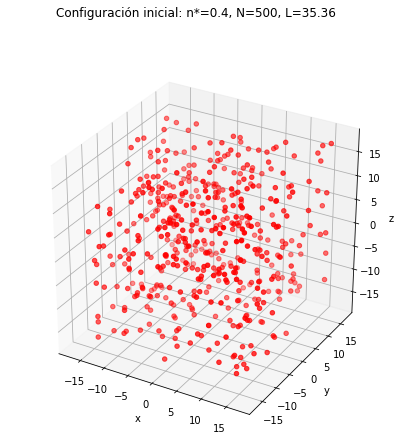

In [115]:
#Graficamos la configuración inicial
fig = plt.figure()
fig.set_size_inches(7,7)
fig.suptitle('Configuración inicial: n*=0.4, N=500, L=35.36')
ax1 = fig.add_subplot(projection='3d')
ax1.scatter(df0['x_0'], df0['y_0'], df0['z_0'], c = 'r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')

Text(0.5, 0, 'z')

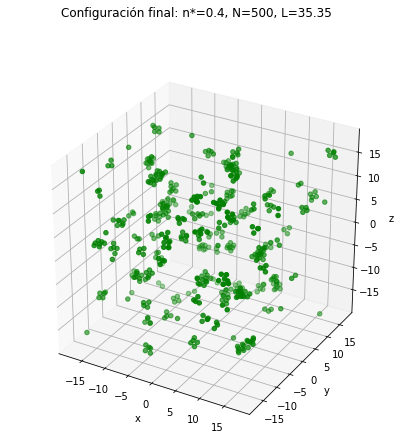

In [116]:
#Graficamos la configuración final
fig = plt.figure()
fig.set_size_inches(7,7)
fig.suptitle('Configuración final: n*=0.4, N=500, L=35.35')
ax2 = fig.add_subplot(projection='3d')
ax2.scatter(df1['x_f'], df1['y_f'], df1['z_f'], c = 'g')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')

Text(0.5, 0, 'z')

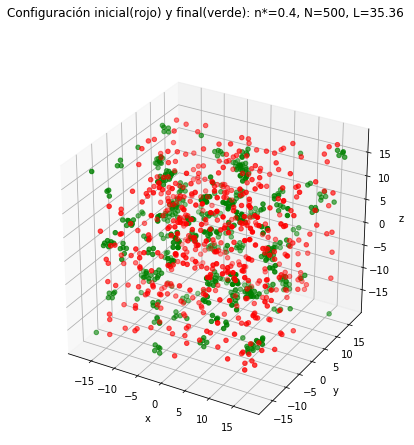

In [117]:
#Graficamos la configuración inicial y final
fig = plt.figure()
fig.set_size_inches(7,7)
fig.suptitle('Configuración inicial(rojo) y final(verde): n*=0.4, N=500, L=35.36')
ax3 = fig.add_subplot(projection='3d')
ax3.scatter(df0['x_0'], df0['y_0'], df0['z_0'], c = 'r')
ax3.scatter(df1['x_f'], df1['y_f'], df1['z_f'], c = 'g')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('z')

Text(0, 0.5, 'Potencial')

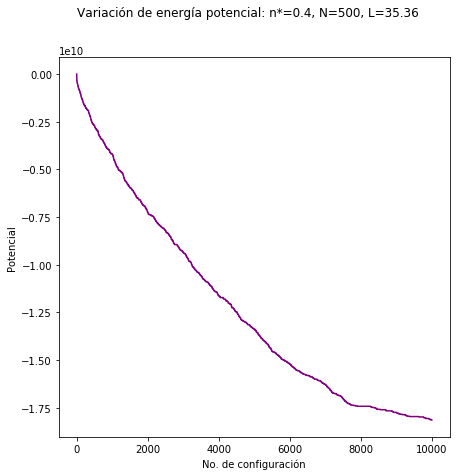

In [122]:
#Graficamos la variación de energía potencial total a través de la variación de configuraciones
fig = plt.figure()
fig.set_size_inches(7,7)
fig.suptitle('Variación de energía potencial: n*=0.4, N=500, L=35.36')
ax4 = fig.add_subplot()
ax4.plot(np.linspace(0,nStep, nStep), vTraza, c = 'purple')
ax4.set_xlabel('No. de configuración')
ax4.set_ylabel('Potencial')

(-17.67766952966369, 17.67766952966369)

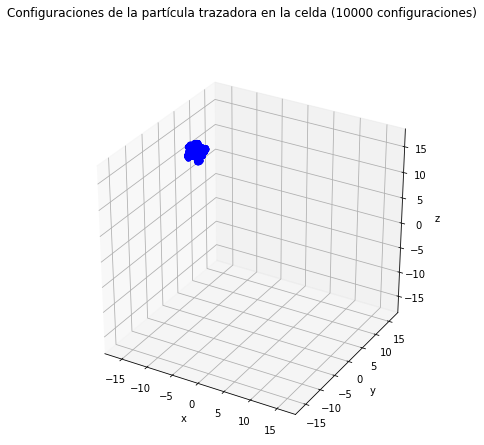

In [127]:
#Graficamos las posiciones de la partícula trazadora a través de los cambios de configuración
fig = plt.figure()
fig.set_size_inches(7,7)
fig.suptitle('Configuraciones de la partícula trazadora en la celda (10000 configuraciones)')
ax5 = fig.add_subplot(projection='3d')
ax5.scatter(dfT['x'], dfT['y'], dfT['z'], c = 'b')
ax5.set_xlabel('x')
ax5.set_ylabel('y')
ax5.set_zlabel('z')
ax5.set_xlim(-L/2, L/2)
ax5.set_ylim(-L/2, L/2)
ax5.set_zlim(-L/2, L/2)

Text(0.5, 0, 'z')

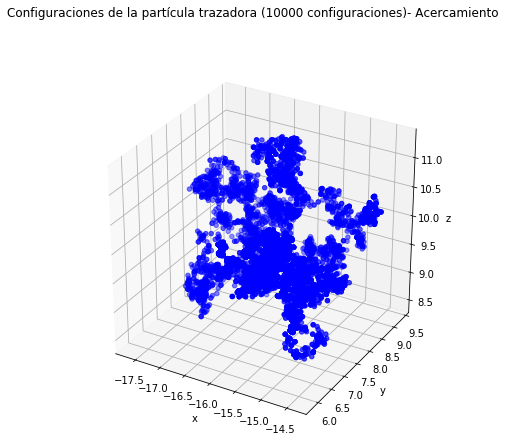

In [128]:
#Graficamos las posiciones de la partícula trazadora a través de los cambios de configuración
fig = plt.figure()
fig.set_size_inches(7,7)
fig.suptitle('Configuraciones de la partícula trazadora (10000 configuraciones)- Acercamiento')
ax5 = fig.add_subplot(projection='3d')
ax5.scatter(dfT['x'], dfT['y'], dfT['z'], c = 'b')
ax5.set_xlabel('x')
ax5.set_ylabel('y')
ax5.set_zlabel('z')